<a href="https://colab.research.google.com/github/filippoalbani/quantum_autoencoders/blob/main/Quantum_Autoencoder_for_Time_Series_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Applying Quantum Autoencoders for Time Series Anomaly Detection**


A remake of the autoencoder proposed in the article "Applying Quantum Autoencoders for Time Series Anomaly Detection", published 10/10/2024, by Robin Frehner, Kurt Stockinger.

Dataset avaliable here: https://www.cs.ucr.edu/~eamonn/time_series_data_2018/ upload it on your Google Drive to make the code work.

In [1]:
pip install torch pandas numpy pennylane pennylane-lightning redis matplotlib tqdm scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.5/261.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 11.5 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from tqdm import tqdm
import copy

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We work with the UCR time series classification archive, which
contains datasets of time series from diverse fields. Each dataset comes along with
a read-me commentary file and is already parted in two .tsv files ready to use
for machine learning purposes: one file for the training, containing no anomalies, and one for the test, containing *one and only one anomaly*. The
.tsv files show matrixes where the first element in the row is the class label (not
relevant in this work). The rest of the row elements are the data sample values. The
order of time series exemplar carry no special meaning and is in most cases random.

**Every time series (row of the dataset) needs to be cut in windows of dimension 128 to be fed to the 7 qubit quantum encoder defined below.**

In [24]:
# Dataset preparation
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size, stride):
        self.data = self.create_sliding_windows(data, window_size, stride)

    def create_sliding_windows(self, data, window_size, stride):
        windows = []
        for series in data:  # Iterate over each time series
            for i in range(0, len(series) - window_size + 1, stride):
                windows.append(series[i:i + window_size])
        return np.array(windows)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32)

In [5]:
# Data preparation
train_file_path = '/content/drive/My Drive/UCRArchive_2018/Fish/Fish_TRAIN.tsv'
test_file_path = '/content/drive/My Drive/UCRArchive_2018/Fish/Fish_TEST.tsv'

def load_data(file_path):
    data = pd.read_csv(file_path, sep='\t', header=None)
    data = data.iloc[:, 1:]  # Remove the first column
    return data

train_data = load_data(train_file_path)
test_data = load_data(test_file_path)

scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Create sliding windows
window_size = 128
stride = 1
train_dataset = TimeSeriesDataset(train_data, window_size, stride)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)



The encoder as defined in the article:

In [7]:
# TRAINABLE ENCODER (variational gates) "PauliTwoDesign with two repetitions"
def PauliTwoDesignWithTwoRepetitions(weights, wires):

        qml.RY(np.pi/4, wires=0)
        qml.RY(np.pi/4, wires=1)
        qml.RY(np.pi/4, wires=2)
        qml.RY(np.pi/4, wires=3)
        qml.RY(np.pi/4, wires=4)
        qml.RY(np.pi/4, wires=5)
        qml.RY(np.pi/4, wires=6)

        qml.RZ(weights[0], wires=0)
        qml.RY(weights[1], wires=1)
        qml.RX(weights[2], wires=2)
        qml.RY(weights[3], wires=3)
        qml.RZ(weights[4], wires=4)
        qml.RX(weights[5], wires=5)
        qml.RX(weights[6], wires=6)

        qml.CZ(wires=[0, 1])
        qml.CZ(wires=[1, 2])
        qml.CZ(wires=[2, 3])
        qml.CZ(wires=[3, 4])
        qml.CZ(wires=[4, 5])
        qml.CZ(wires=[5, 6])

        qml.RY(weights[7], wires=0)
        qml.RZ(weights[8], wires=1)
        qml.RX(weights[9], wires=2)
        qml.RZ(weights[10], wires=3)
        qml.RX(weights[11], wires=4)
        qml.RX(weights[12], wires=5)
        qml.RX(weights[13], wires=6)

        qml.CZ(wires=[0, 1])
        qml.CZ(wires=[1, 2])
        qml.CZ(wires=[2, 3])
        qml.CZ(wires=[3, 4])
        qml.CZ(wires=[4, 5])
        qml.CZ(wires=[5, 6])

        qml.RX(weights[14], wires=0)
        qml.RX(weights[15], wires=1)
        qml.RY(weights[16], wires=2)
        qml.RY(weights[17], wires=3)
        qml.RX(weights[18], wires=4)
        qml.RY(weights[19], wires=5)
        qml.RY(weights[20], wires=6)


# #QUASI AMPLITUDE ENCODING (useful alternative for real quantum hardware)

def QuasiAmplitudeEncoding(weights, wires):

        qml.RY(0.578, wires=0)  #(ANGLE_OF_ROTATION, wires=QUBIT_TO_ROTATE)
        qml.RY(0.224, wires=1)
        qml.RY(0.387, wires=2)
        qml.RY(0.204, wires=3)
        qml.RY(0.210, wires=4)
        qml.RY(0.367, wires=5)
        qml.RY(0.780, wires=6)

        qml.RZ(0.101, wires=0)
        qml.RZ(0.337, wires=1)
        qml.RZ(0.430, wires=2)
        qml.RZ(0.501, wires=3)
        qml.RZ(0.215, wires=4)
        qml.RZ(0.933, wires=5)
        qml.RZ(0.169, wires=6)

        qml.CNOT(wires=[6, 0])  #(wires=[CONTROL, TARGET])
        qml.CNOT(wires=[0, 1])
        qml.CNOT(wires=[1, 2])
        qml.CNOT(wires=[2, 3])
        qml.CNOT(wires=[3, 4])
        qml.CNOT(wires=[4, 5])
        qml.CNOT(wires=[5, 6])

        qml.RY(0.406, wires=0)
        qml.RY(0.118, wires=1)
        qml.RY(0.366, wires=2)
        qml.RY(0.232, wires=3)
        qml.RY(0.816, wires=4)
        qml.RY(0.696, wires=5)
        qml.RY(0.353, wires=6)

        qml.RZ(0.699, wires=0)
        qml.RZ(0.887, wires=1)
        qml.RZ(0.0979, wires=2)
        qml.RZ(0.0109, wires=3)
        qml.RZ(0.145, wires=4)
        qml.RZ(0.224, wires=5)
        qml.RZ(0.670, wires=6)

        qml.CNOT(wires=[6, 5])
        qml.CNOT(wires=[0, 6])
        qml.CNOT(wires=[1, 0])
        qml.CNOT(wires=[2, 1])
        qml.CNOT(wires=[3, 2])
        qml.CNOT(wires=[4, 3])
        qml.CNOT(wires=[5, 4])

        qml.RY(0.289, wires=0)
        qml.RY(0.577, wires=1)
        qml.RY(0.990, wires=2)
        qml.RY(0.028, wires=3)
        qml.RY(0.0959, wires=4)
        qml.RY(0.953, wires=5)
        qml.RY(0.194, wires=6)

        qml.RZ(0.832, wires=0)
        qml.RZ(0.788, wires=1)
        qml.RZ(0.0319, wires=2)
        qml.RZ(0.496, wires=3)
        qml.RZ(0.228, wires=4)
        qml.RZ(0.0255, wires=5)
        qml.RZ(0.980, wires=6)




# Quantum Encoder circuit with Amplitude Encoding
def get_quantum_node(num_qubits, dev):
    def quantum_circuit(inputs, weights):

        # Amplitude Encoding
        qml.AmplitudeEmbedding(inputs, wires=range(num_qubits), pad_with=0, normalize=True)

        PauliTwoDesignWithTwoRepetitions(weights=weights, wires=range(num_qubits))


        # SWAP-TEST which measures how well the encoder circuit encodes the input data

        qml.Hadamard(wires=8)
        qml.CSWAP(wires=[8, 6, 7])
        qml.Hadamard(wires=8)


        return qml.probs(wires=7)

    return quantum_circuit

In [8]:
# Quantum Encoder integration in PyTorch model
class QuantumEncoder(nn.Module):
    def __init__(self, num_qubits):
        super(QuantumEncoder, self).__init__()
        self.num_qubits = num_qubits
        self.dev = qml.device("lightning.qubit", wires=num_qubits + 2, shots=1024)
        self.weights = nn.Parameter(torch.rand(63) * np.pi)
        self.qnode = qml.QNode(get_quantum_node(num_qubits, self.dev), self.dev)

    def forward(self, x):
        # x = x / torch.norm(x, dim=1, keepdim=True)  # Normalize input
        swap_test_probs = []
        for window in x:
          probs = self.qnode(window, self.weights)
          prob_1 = probs[1]
          swap_test_probs.append(prob_1)

        return torch.stack(swap_test_probs) # Use torch.stack to keep the computational graph

In [9]:
# Train the Quantum Encoder
num_qubits = 7
encoder = QuantumEncoder(num_qubits)

# Training Loop
epochs = 20
optimizer = torch.optim.Adam(encoder.parameters(), lr=0.001)

best_loss = float('inf')
patience = 10
trigger_times = 0
best_encoder = None

# Without early stopping the training would take hours,
# due to the complexity of the simulations of 9 quibits systems.
loss_threshold = 0.001

for epoch in range(epochs):
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}")
    for i, batch in progress_bar:
        optimizer.zero_grad()
        # Get the probability of measuring |1> on qubit 8, which is the swap test result
        swap_test_results = encoder(batch)
        # Loss is the probability of measuring |1>
        loss = torch.mean(swap_test_results)
        # We want to minimize the probability of measuring |1>, so that qubits 6 and 7 are as similar as possible
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()}) # Add loss to the progress bar

        # Early stopping check
        if loss.item() < loss_threshold:  # if the current batch loss is already below the loss threshold
            print(f'Early stopping at epoch {epoch + 1}, batch {i + 1} since loss {loss.item()} is below threshold {loss_threshold}')
            break  # Exit the inner loop (batch iteration)


    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Avg. Loss: {avg_epoch_loss}")

    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        best_encoder_state_dict = encoder.state_dict()
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f'Early stopping at epoch {epoch+1} since the loss did not improve for {patience} epochs')
            break

if best_encoder_state_dict is not None:
    print("Loading best model")
    best_encoder = QuantumEncoder(num_qubits)  # Create a new instance
    best_encoder.load_state_dict(best_encoder_state_dict)
    encoder = best_encoder

Epoch 1/20:   2%|▏         | 1129/58800 [01:43<1:28:23, 10.87it/s, loss=0.000977]


Early stopping at epoch 1, batch 1130 since loss 0.0009765625 is below threshold 0.001
Epoch 1/20, Avg. Loss: 0.0008399267910289116


Epoch 2/20:   0%|          | 10/58800 [00:00<1:17:46, 12.60it/s, loss=0.000977]


Early stopping at epoch 2, batch 11 since loss 0.0009765625 is below threshold 0.001
Epoch 2/20, Avg. Loss: 8.470184948979592e-07


Epoch 3/20:   0%|          | 36/58800 [00:02<1:16:49, 12.75it/s, loss=0.000977]


Early stopping at epoch 3, batch 37 since loss 0.0009765625 is below threshold 0.001
Epoch 3/20, Avg. Loss: 3.2386001275510203e-06


Epoch 4/20:   0%|          | 17/58800 [00:01<1:39:51,  9.81it/s, loss=0.000977]


Early stopping at epoch 4, batch 18 since loss 0.0009765625 is below threshold 0.001
Epoch 4/20, Avg. Loss: 1.0463169642857143e-06


Epoch 5/20:   0%|          | 4/58800 [00:00<2:15:15,  7.24it/s, loss=0.000977]


Early stopping at epoch 5, batch 5 since loss 0.0009765625 is below threshold 0.001
Epoch 5/20, Avg. Loss: 3.985969387755102e-07


Epoch 6/20:   0%|          | 0/58800 [00:00<?, ?it/s, loss=0.000977]


Early stopping at epoch 6, batch 1 since loss 0.0009765625 is below threshold 0.001
Epoch 6/20, Avg. Loss: 1.6608205782312925e-08


Epoch 7/20:   0%|          | 14/58800 [00:01<1:54:53,  8.53it/s, loss=0.000977]


Early stopping at epoch 7, batch 15 since loss 0.0009765625 is below threshold 0.001
Epoch 7/20, Avg. Loss: 9.964923469387756e-07


Epoch 8/20:   0%|          | 8/58800 [00:00<1:42:57,  9.52it/s, loss=0.000977]


Early stopping at epoch 8, batch 9 since loss 0.0009765625 is below threshold 0.001
Epoch 8/20, Avg. Loss: 7.473692602040816e-07


Epoch 9/20:   0%|          | 4/58800 [00:00<2:15:22,  7.24it/s, loss=0.000977]


Early stopping at epoch 9, batch 5 since loss 0.0009765625 is below threshold 0.001
Epoch 9/20, Avg. Loss: 2.3251488095238095e-07


Epoch 10/20:   0%|          | 5/58800 [00:00<1:26:27, 11.33it/s, loss=0.000977]


Early stopping at epoch 10, batch 6 since loss 0.0009765625 is below threshold 0.001
Epoch 10/20, Avg. Loss: 3.8198873299319727e-07


Epoch 11/20:   0%|          | 11/58800 [00:00<1:14:36, 13.13it/s, loss=0.000977]


Early stopping at epoch 11, batch 12 since loss 0.0009765625 is below threshold 0.001
Epoch 11/20, Avg. Loss: 7.307610544217688e-07


Epoch 12/20:   0%|          | 4/58800 [00:00<1:28:47, 11.04it/s, loss=0.000977]


Early stopping at epoch 12, batch 5 since loss 0.0009765625 is below threshold 0.001
Epoch 12/20, Avg. Loss: 2.657312925170068e-07


Epoch 13/20:   0%|          | 10/58800 [00:00<1:17:16, 12.68it/s, loss=0]


Early stopping at epoch 13, batch 11 since loss 0.0 is below threshold 0.001
Epoch 13/20, Avg. Loss: 5.812872023809524e-07


Epoch 14/20:   0%|          | 1/58800 [00:00<2:25:14,  6.75it/s, loss=0.000977]


Early stopping at epoch 14, batch 2 since loss 0.0009765625 is below threshold 0.001
Epoch 14/20, Avg. Loss: 8.304102891156462e-08


Epoch 15/20:   0%|          | 2/58800 [00:00<1:46:54,  9.17it/s, loss=0.000977]


Early stopping at epoch 15, batch 3 since loss 0.0009765625 is below threshold 0.001
Epoch 15/20, Avg. Loss: 9.964923469387755e-08


Epoch 16/20:   0%|          | 7/58800 [00:00<1:47:06,  9.15it/s, loss=0.000977]

Early stopping at epoch 16, batch 8 since loss 0.0009765625 is below threshold 0.001
Epoch 16/20, Avg. Loss: 4.816379676870749e-07
Early stopping at epoch 16 since the loss did not improve for 10 epochs
Loading best model


In [10]:
# Anomaly Detection

test_dataset = TimeSeriesDataset(test_data, window_size, stride)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

anomalies = []
threshold = 0.1  # Threshold for considering the states different
normal_probs = []

progress_bar = tqdm(enumerate(test_loader), total=len(test_loader), desc="Processing Test Samples")

for i, test_sample in progress_bar:
    prob_1 = encoder(test_sample).item()
    normal_probs.append(prob_1)
    if prob_1 > threshold:  # Corrected: Check if prob_1 is above threshold
        anomalies.append(i)

print(f"Detected anomalies at window indices: {anomalies}")



Processing Test Samples: 100%|██████████| 58800/58800 [05:17<00:00, 184.95it/s]

Detected anomalies at window indices: [29904, 29905, 29906, 29907, 29908, 29909, 29910, 29911, 29912, 29913, 29914, 29915, 29916]


In [11]:
def get_timeseries_index_from_window_index(window_index, window_size, stride, num_timeseries):
    windows_per_timeseries = (num_timeseries - window_size + stride) // stride
    timeseries_indices = [index // windows_per_timeseries for index in window_index] # Iterate through each index in the window_index list (anomalies)

    return timeseries_indices  # Return the list of timeseries indices


timeseries_indices = get_timeseries_index_from_window_index(anomalies, window_size, stride, test_data.shape[1])
print(f"The anomalous windows belong to time series indices: {timeseries_indices}") #Updated print statement

The anomalous windows belong to time series indices: [89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89, 89]


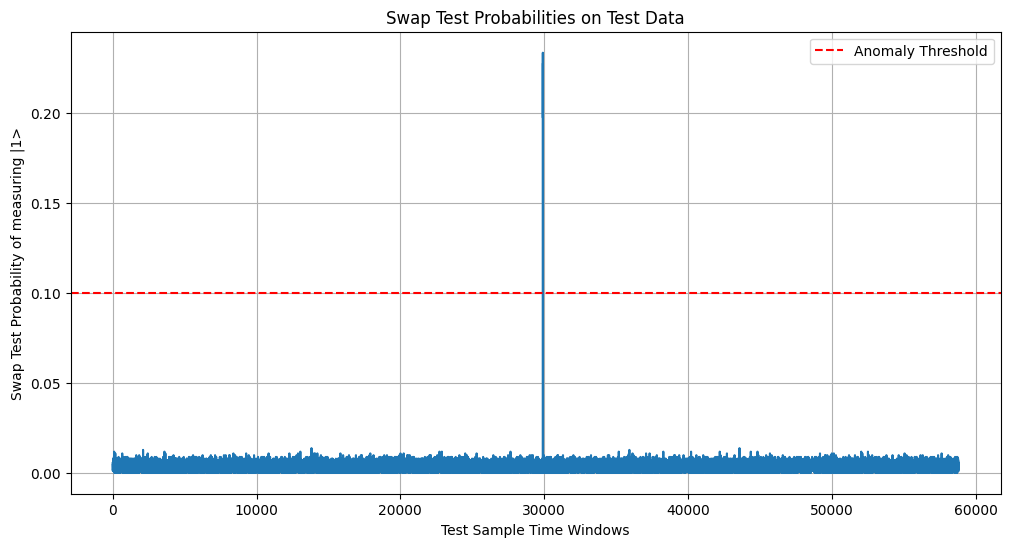

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(normal_probs)
plt.xlabel('Test Sample Time Windows')
plt.ylabel('Swap Test Probability of measuring |1>')
plt.title('Swap Test Probabilities on Test Data')
plt.axhline(y=0.1, color='r', linestyle='--', label='Anomaly Threshold')
plt.legend()
plt.grid(True)
plt.show()

Now we build the whole autoencoder, again following the structure in the article.

In [14]:
class QuantumAutoencoder(nn.Module):
    def __init__(self, num_qubits, encoder_weights):
        super(QuantumAutoencoder, self).__init__()
        self.num_qubits = num_qubits
        self.dev = qml.device("lightning.qubit", wires=num_qubits + 1, shots=1024)  # Extra wire for ancillary qubit
        self.encoder_weights = encoder_weights  # Pre-trained encoder weights

        # Define the autoencoder circuit
        def autoencoder_circuit(weights):
            @qml.qnode(self.dev)
            def autoencoder_qnode(inputs):
                # Amplitude embedding for the input
                qml.AmplitudeEmbedding(inputs, wires=range(num_qubits), pad_with=0, normalize=True)

                # Apply the PauliTwoDesign encoder
                PauliTwoDesignWithTwoRepetitions(weights=weights, wires=range(num_qubits))

                # Reset qubit 6 using the ancillary qubit
                qml.SWAP(wires=[6, num_qubits])  # Ancillary qubit at index `num_qubits`

                # Apply the adjoint of PauliTwoDesign
                qml.adjoint(PauliTwoDesignWithTwoRepetitions)(weights=weights, wires=range(num_qubits))

                # Measure probabilities
                return qml.probs(wires=range(num_qubits))

            return autoencoder_qnode

        # Create the autoencoder QNode
        self.autoencoder_qnode = autoencoder_circuit(self.encoder_weights)

    def forward(self, x):
        reconstructed_windows = []
        for window in x:
            # Use the autoencoder to get probabilities
            probs = self.autoencoder_qnode(window)
            # Map probabilities to the reconstructed window
            reconstructed_window = probs[:len(window)]
            reconstructed_windows.append(reconstructed_window)

        return torch.stack(reconstructed_windows)  # Convert to PyTorch tensor


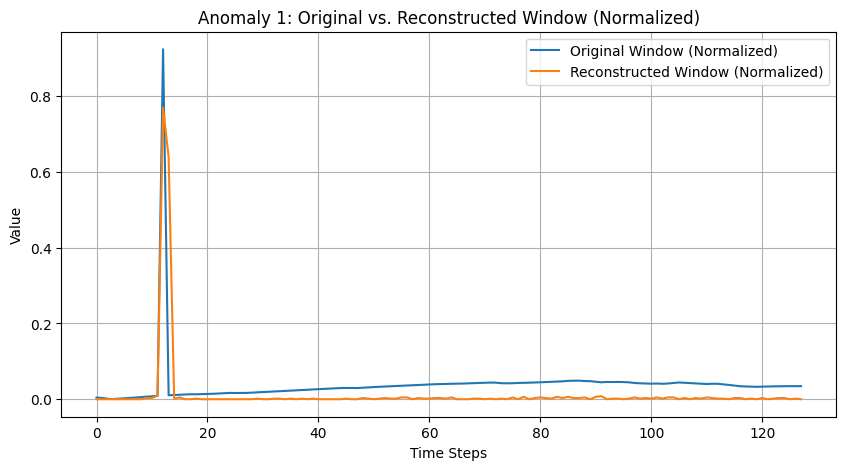

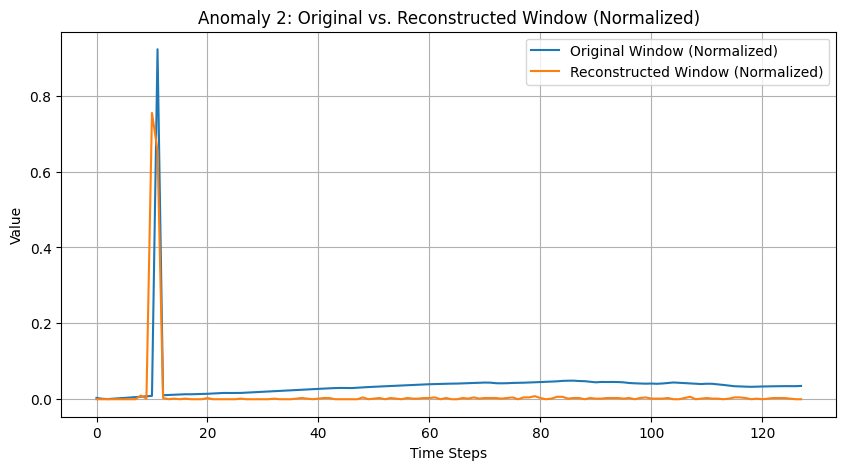

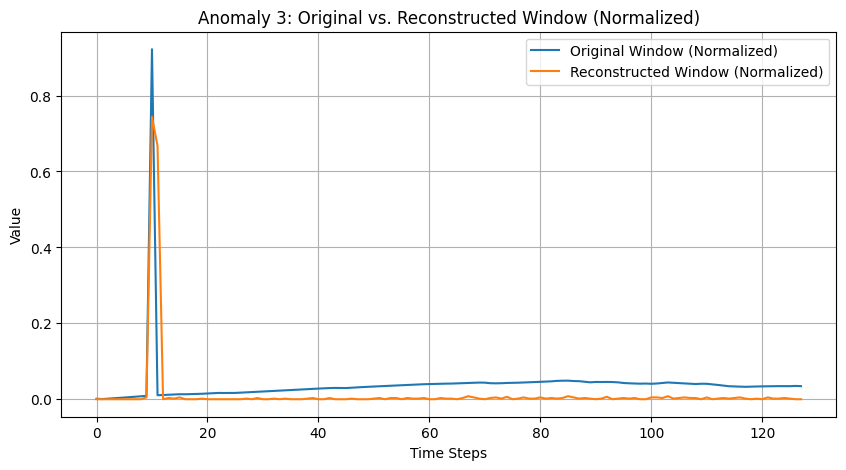

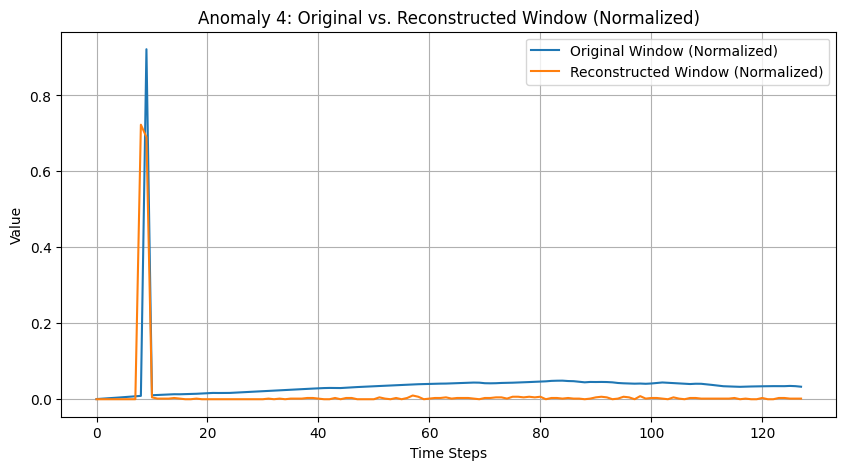

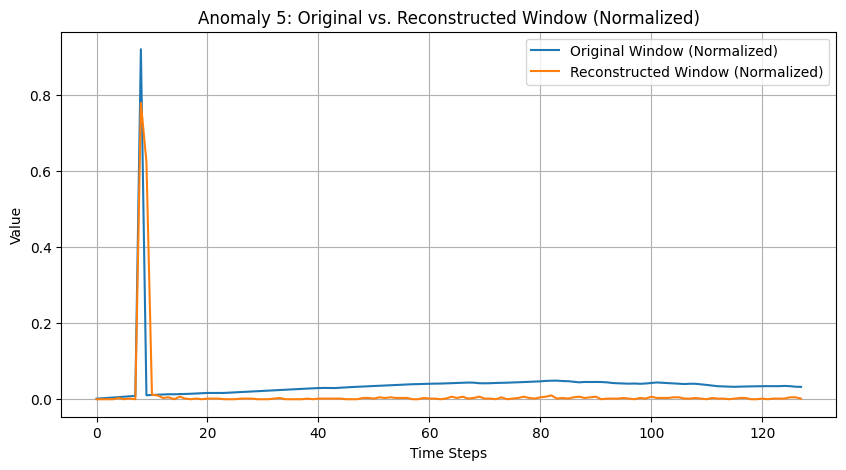

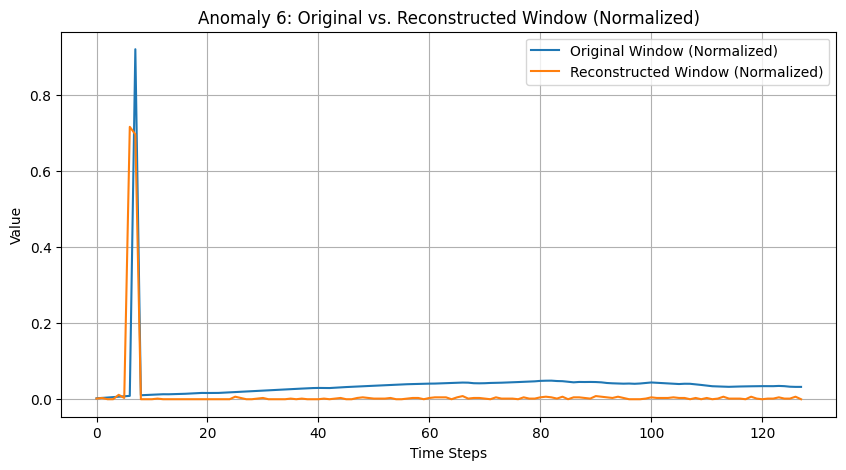

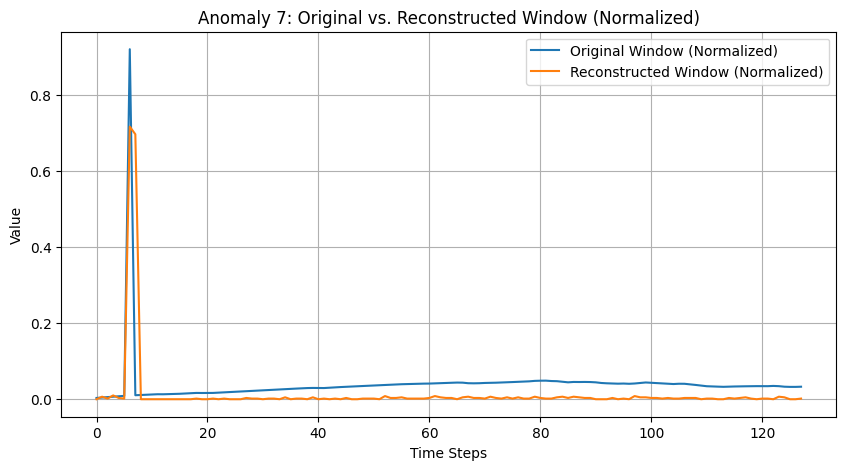

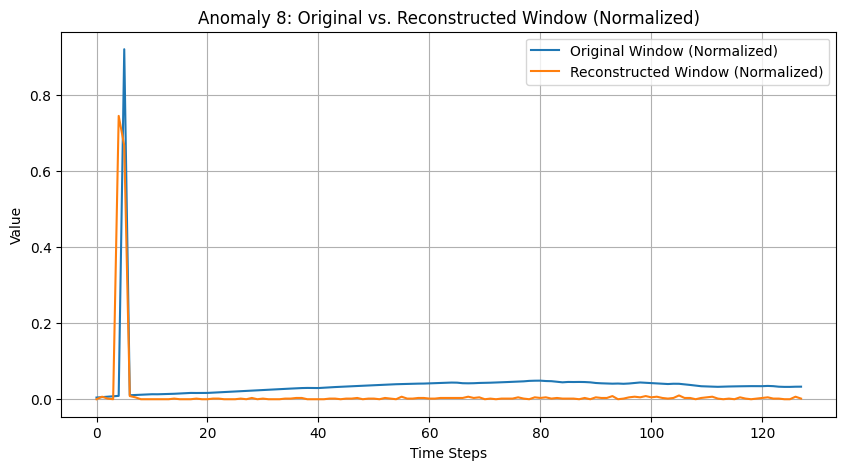

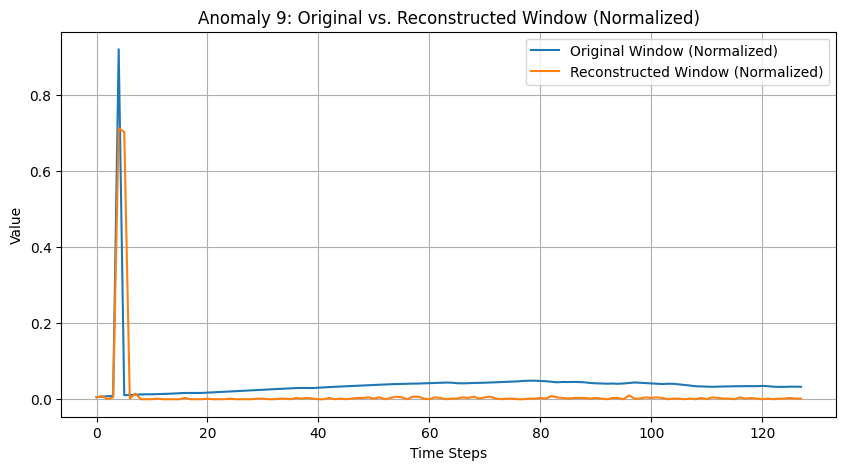

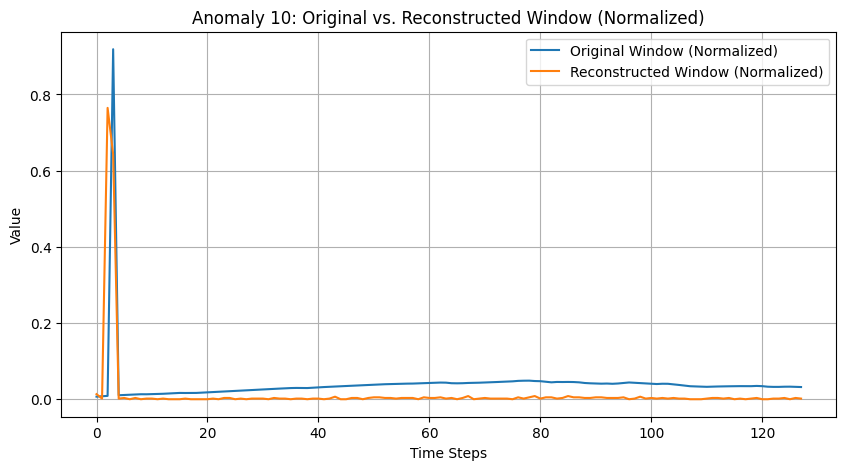

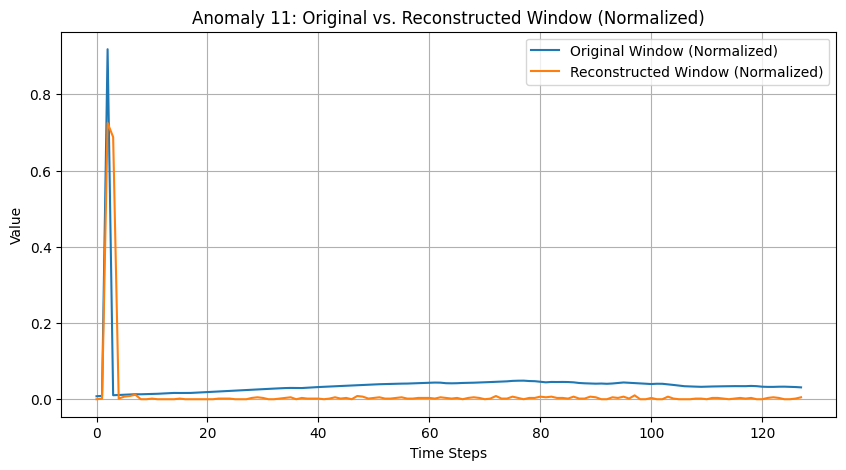

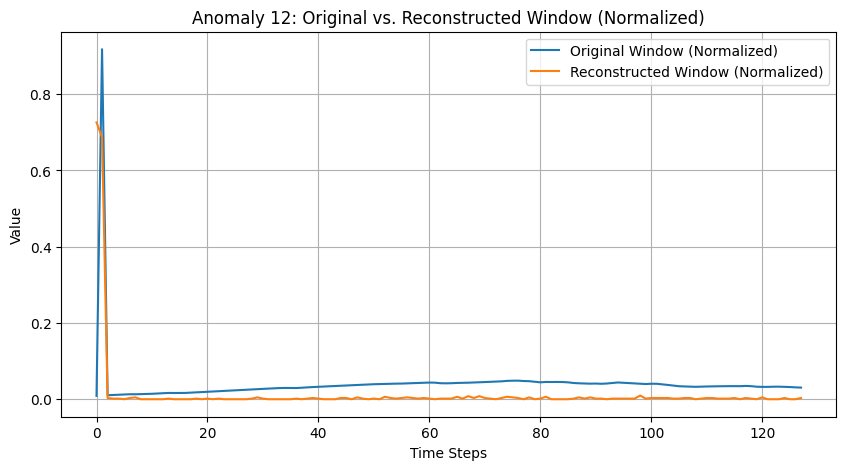

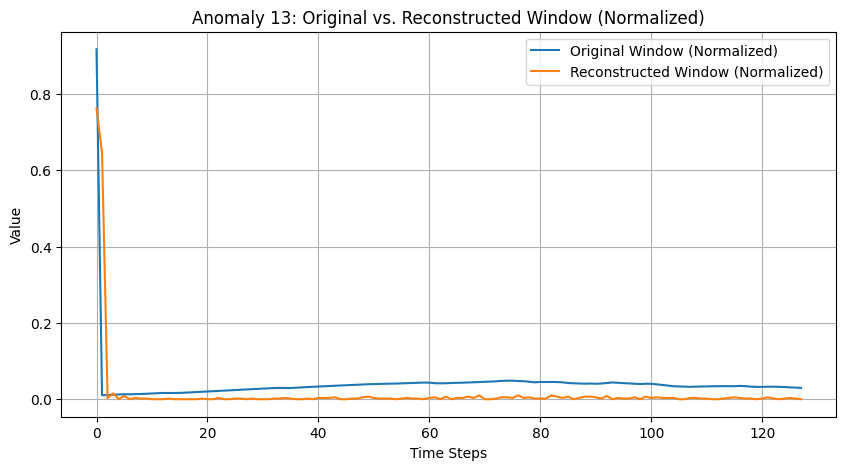

In [15]:
# Create the Quantum Autoencoder
autoencoder = QuantumAutoencoder(num_qubits, encoder.weights) # Using the trained encoder's weights

# Pass the anomalous windows through the autoencoder and plot the results
anomalous_windows = [test_dataset[i] for i in anomalies]  # Get the anomalous windows from the test dataset
anomalous_reconstructed_windows = autoencoder(anomalous_windows)  # Get the reconstructed windows

# Plot the original and reconstructed windows for each anomaly
for i, (original_window, anomalous_reconstructed_window) in enumerate(zip(anomalous_windows, anomalous_reconstructed_windows)):
    plt.figure(figsize=(10, 5))

    # Normalize the original and reconstructed windows
    original_window_normalized = original_window / torch.norm(original_window)
    reconstructed_window_normalized = anomalous_reconstructed_window / torch.norm(anomalous_reconstructed_window)

    # Plot the original window
    plt.plot(original_window_normalized.detach().numpy(), label="Original Window (Normalized)")

    # Plot the reconstructed window (normalized)
    plt.plot(reconstructed_window_normalized.detach().numpy(), label="Reconstructed Window (Normalized)")

    plt.title(f"Anomaly {i + 1}: Original vs. Reconstructed Window (Normalized)")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

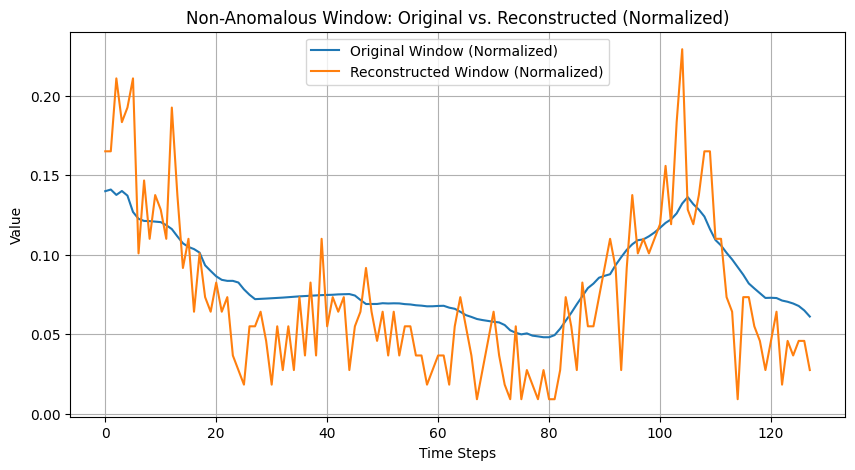

In [16]:
non_anomalous_index = 0  # For example, the first window in the test dataset

# Get the non-anomalous window
non_anomalous_window = test_dataset[non_anomalous_index]

# Pass the non-anomalous window through the autoencoder
reconstructed_window = autoencoder([non_anomalous_window])

# Normalize the original and reconstructed windows
original_window_normalized = non_anomalous_window / torch.norm(non_anomalous_window)
reconstructed_window_normalized = reconstructed_window[0] / torch.norm(reconstructed_window[0])  # Access the first element since it's in a list

# Plot the original and reconstructed windows
plt.figure(figsize=(10, 5))
plt.plot(original_window_normalized.detach().numpy(), label="Original Window (Normalized)")
plt.plot(reconstructed_window_normalized.detach().numpy(), label="Reconstructed Window (Normalized)")
plt.title("Non-Anomalous Window: Original vs. Reconstructed (Normalized)")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
reconstructed_windows = autoencoder(test_dataset)

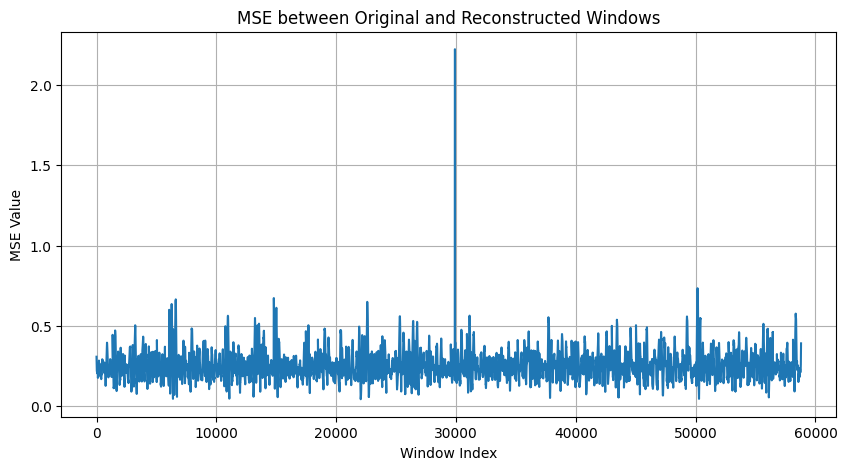

In [19]:
mse_values = []
for original_window, reconstructed_window in zip(test_dataset, reconstructed_windows):
    mse = nn.MSELoss()(original_window, reconstructed_window)
    mse_values.append(mse.item())

plt.figure(figsize=(10, 5))
plt.plot(mse_values)
plt.title("MSE between Original and Reconstructed Windows")
plt.xlabel("Window Index")
plt.ylabel("MSE Value")
plt.grid(True)
plt.show()

During its training, this quantum autoencoder quickly reaches a very low loss. This translates to a quite high fidelity in the reconstruction of the time windows. Still, the anomalous windows have a five times bigger MSE than the non anomalous ones.